# EDA enriquesido

In [1]:
import os
import requests
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: nicer visuals
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

os.chdir('c:/Users/artur/OneDrive/Documents/TrabajoTesis') 

In [2]:
df = pd.read_csv("Bases/faenas_with_accessibility.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RutEmpresa                  2116 non-null   object 
 1   NombreEmpresa               2116 non-null   object 
 2   CategoriaFaena              2116 non-null   object 
 3   ProvinciaInstalacion        2116 non-null   object 
 4   ComunaInstalacion           2116 non-null   object 
 5   IdTipoInstalacion           2116 non-null   int64  
 6   TipoInstalacion             2116 non-null   object 
 7   RecursoPrimarioInstalacion  2116 non-null   object 
 8   Cota                        2116 non-null   int64  
 9   Huso                        2116 non-null   int64  
 10  IdEstado                    2116 non-null   int64  
 11  Estado                      2116 non-null   object 
 12  Latitud                     2116 non-null   float64
 13  Longitud                    2116 

In [4]:
drop = ['Lon_Puerto_cercana', 'Lat_Puerto_cercana', 'Dist_Puerto_km','Puerto_cercana','Dist_Estacion_km','Lon_Estacion_cercana','Lat_Estacion_cercana','Estacion_cercana','Dist_Desalinadora_km','Lon_Desalinadora_cercana','Lat_Desalinadora_cercana','Desalinadora_cercana']
df = df.drop(columns=drop)

In [5]:
df = df.rename(columns={'TravelTime_Truck_min': 'TimeCiudad', 'DriveTime_Desalinadora_min': 'TimeDesal', 'DriveTime_Estacion_min': 'TimeEstacion', 'DriveTime_Puerto_min': 'TimePuerto'})

In [6]:
df.head()

,RutEmpresa,NombreEmpresa,CategoriaFaena,ProvinciaInstalacion,ComunaInstalacion,IdTipoInstalacion,TipoInstalacion,RecursoPrimarioInstalacion,Cota,Huso,IdEstado,Estado,Latitud,Longitud,Closest_City,TimeCiudad,TimeDesal,TimeEstacion,TimePuerto
0,76043345-4,SCM CAMARONES,CATEGORIA D,ARICA,ARICA,8073,CANCHA DE ACOPIO,COBRE,181,19,12,ABANDONADA,-18.766115,-70.305866,Arica,64.160000,62.835000,63.476667,569.841667
1,10267925-3,OMAR MUÑOZ ALVAREZ,CATEGORIA D,CHOAPA,CANELA,1291,MINA SUBTERRANEA,COBRE,1100,19,8,ACTIVA,-31.187356,-71.307579,Coquimbo,186.573333,126.293333,204.753333,964.756667
2,76828678-7,MINERA JESSICA PAMELA PEREZ SILVA EIRL,CATEGORIA D,PETORCA,CABILDO,8076,EXPLORACIÓN SUBTERRÁNEA,COBRE,475,19,8,ACTIVA,-32.413654,-70.932892,Valparaíso,140.648333,102.423333,103.946667,1042.293333
3,76102677-1,MINERA HMC S.A.,CATEGORIA A,ANTOFAGASTA,MEJILLONES,1350,TALLERES Y MAESTRANZA,COBRE,765,19,8,ACTIVA,-22.676943,-70.189357,Antofagasta,132.145000,3.201667,133.496667,86.495000
4,12774379-7,JULIO CESAR CONTRERAS ELGUETA,CATEGORIA D,SAN FELIPE,CATEMU,1306,PLANTA EXTRACCIÓN POR SOLVENTES,COBRE,789,19,12,ABANDONADA,-32.682402,-70.976678,Valparaíso,116.875000,118.035000,38.565000,1076.221667


In [7]:
df2 = pd.read_excel("Cluster/Faenas25.xlsx")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28319 entries, 0 to 28318
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RutEmpresa                   28319 non-null  object 
 1    NombreEmpresa               28319 non-null  object 
 2    RegionFaena                 28319 non-null  object 
 3    ProvinciaFaena              28319 non-null  object 
 4    ComunaFaena                 28319 non-null  object 
 5    NombreFaena                 28319 non-null  object 
 6    CategoriaFaena              28319 non-null  object 
 7    IdFaena                     28319 non-null  int64  
 8    RegionInstalacion           28319 non-null  object 
 9    ProvinciaInstalacion        28319 non-null  object 
 10   ComunaInstalacion           28319 non-null  object 
 11   NombreInstalacion           28319 non-null  object 
 12   IdTipoInstalacion           28319 non-null  int64  
 13   TipoInstalacion

In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# --- Ensure numeric coordinates in df ---
df["Latitud"] = df["Latitud"].astype(str).str.replace(",", ".").astype(float)
df["Longitud"] = df["Longitud"].astype(str).str.replace(",", ".").astype(float)

# --- Copy and clean df2 (Cluster/Faenas25) ---
Cluster = df2.copy()
Cluster.columns = Cluster.columns.str.strip()  # remove leading/trailing spaces
Cluster["Latitud"] = Cluster["Latitud"].astype(str).str.replace(",", ".").astype(float)
Cluster["Longitud"] = Cluster["Longitud"].astype(str).str.replace(",", ".").astype(float)

# --- Build BallTree for nearest neighbor search ---
earth_radius = 6371  # km
tree = BallTree(np.deg2rad(Cluster[["Latitud", "Longitud"]].values), metric="haversine")

# --- Find nearest Cluster/Faenas25 point for each df row ---
distances, indices = tree.query(np.deg2rad(df[["Latitud", "Longitud"]].values), k=1)

# --- Add corresponding RegionInstalacion from Cluster/Faenas25 ---
df["RegionInstalacion"] = Cluster.iloc[indices.flatten()]["RegionInstalacion"].values

# --- (Optional) add distance in km to check matching accuracy ---
df["DistanciaCluster_km"] = distances.flatten() * earth_radius

print("✅ Región asignada a cada faena según el punto más cercano del Cluster/Faenas25")
print("Distancia promedio (km):", round(df["DistanciaCluster_km"].mean(), 2))
print("Distancia máxima (km):", round(df["DistanciaCluster_km"].max(), 2))




✅ Región asignada a cada faena según el punto más cercano del Cluster/Faenas25
Distancia promedio (km): 0.0
Distancia máxima (km): 0.0


In [9]:
df = df.drop(columns=["DistanciaCluster_km"])
df.head()

,RutEmpresa,NombreEmpresa,CategoriaFaena,ProvinciaInstalacion,ComunaInstalacion,IdTipoInstalacion,TipoInstalacion,RecursoPrimarioInstalacion,Cota,Huso,IdEstado,Estado,Latitud,Longitud,Closest_City,TimeCiudad,TimeDesal,TimeEstacion,TimePuerto,RegionInstalacion
0,76043345-4,SCM CAMARONES,CATEGORIA D,ARICA,ARICA,8073,CANCHA DE ACOPIO,COBRE,181,19,12,ABANDONADA,-18.766115,-70.305866,Arica,64.160000,62.835000,63.476667,569.841667,ARICA Y PARINACOTA
1,10267925-3,OMAR MUÑOZ ALVAREZ,CATEGORIA D,CHOAPA,CANELA,1291,MINA SUBTERRANEA,COBRE,1100,19,8,ACTIVA,-31.187356,-71.307579,Coquimbo,186.573333,126.293333,204.753333,964.756667,COQUIMBO
2,76828678-7,MINERA JESSICA PAMELA PEREZ SILVA EIRL,CATEGORIA D,PETORCA,CABILDO,8076,EXPLORACIÓN SUBTERRÁNEA,COBRE,475,19,8,ACTIVA,-32.413654,-70.932892,Valparaíso,140.648333,102.423333,103.946667,1042.293333,VALPARAISO
3,76102677-1,MINERA HMC S.A.,CATEGORIA A,ANTOFAGASTA,MEJILLONES,1350,TALLERES Y MAESTRANZA,COBRE,765,19,8,ACTIVA,-22.676943,-70.189357,Antofagasta,132.145000,3.201667,133.496667,86.495000,ANTOFAGASTA
4,12774379-7,JULIO CESAR CONTRERAS ELGUETA,CATEGORIA D,SAN FELIPE,CATEMU,1306,PLANTA EXTRACCIÓN POR SOLVENTES,COBRE,789,19,12,ABANDONADA,-32.682402,-70.976678,Valparaíso,116.875000,118.035000,38.565000,1076.221667,VALPARAISO


#### Basicos

In [10]:
print("Shape:", df.shape)
print("\n Column Names:\n", df.columns.tolist())
print("\n Info:")
print(df.info())

Shape: (2116, 20)

 Column Names:
 ['RutEmpresa', 'NombreEmpresa', 'CategoriaFaena', 'ProvinciaInstalacion', 'ComunaInstalacion', 'IdTipoInstalacion', 'TipoInstalacion', 'RecursoPrimarioInstalacion', 'Cota', 'Huso', 'IdEstado', 'Estado', 'Latitud', 'Longitud', 'Closest_City', 'TimeCiudad', 'TimeDesal', 'TimeEstacion', 'TimePuerto', 'RegionInstalacion']

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RutEmpresa                  2116 non-null   object 
 1   NombreEmpresa               2116 non-null   object 
 2   CategoriaFaena              2116 non-null   object 
 3   ProvinciaInstalacion        2116 non-null   object 
 4   ComunaInstalacion           2116 non-null   object 
 5   IdTipoInstalacion           2116 non-null   int64  
 6   TipoInstalacion             2116 non-null   object 
 7   RecursoPrima

In [11]:
print("\n Missing Values:\n", df.isna().sum())
print("\n First Rows:\n", df.head())


 Missing Values:
 RutEmpresa                    0
NombreEmpresa                 0
CategoriaFaena                0
ProvinciaInstalacion          0
ComunaInstalacion             0
IdTipoInstalacion             0
TipoInstalacion               0
RecursoPrimarioInstalacion    0
Cota                          0
Huso                          0
IdEstado                      0
Estado                        0
Latitud                       0
Longitud                      0
Closest_City                  0
TimeCiudad                    0
TimeDesal                     0
TimeEstacion                  0
TimePuerto                    0
RegionInstalacion             0
dtype: int64

 First Rows:
    RutEmpresa                           NombreEmpresa CategoriaFaena  \
0  76043345-4                           SCM CAMARONES    CATEGORIA D   
1  10267925-3                      OMAR MUÑOZ ALVAREZ    CATEGORIA D   
2  76828678-7  MINERA JESSICA PAMELA PEREZ SILVA EIRL    CATEGORIA D   
3  76102677-1            

In [12]:
print("\n Numeric Summary:\n", df.describe().T)
print("\n Categorical Summary:\n", df.describe(include='object').T)


 Numeric Summary:
                     count         mean          std          min          25%  \
IdTipoInstalacion  2116.0  2091.619093  2006.411564  1291.000000  1291.000000   
Cota               2116.0  1178.073251   776.897882     0.000000   680.000000   
Huso               2116.0    19.000000     0.000000    19.000000    19.000000   
IdEstado           2116.0   593.636106  1457.316741     8.000000     8.000000   
Latitud            2116.0   -28.634560     3.566150   -35.888489   -31.686987   
Longitud           2116.0   -70.570856     0.583436   -71.894104   -71.042899   
TimeCiudad         2116.0   150.439249    83.308646     3.681667    95.204167   
TimeDesal          2116.0   133.972204    80.547613     0.000000    88.004583   
TimeEstacion       2116.0   187.543854   138.133636     0.353333    89.895000   
TimePuerto         2116.0   712.686652   320.921185    29.256667   477.635417   

                           50%          75%          max  
IdTipoInstalacion  1294.00000

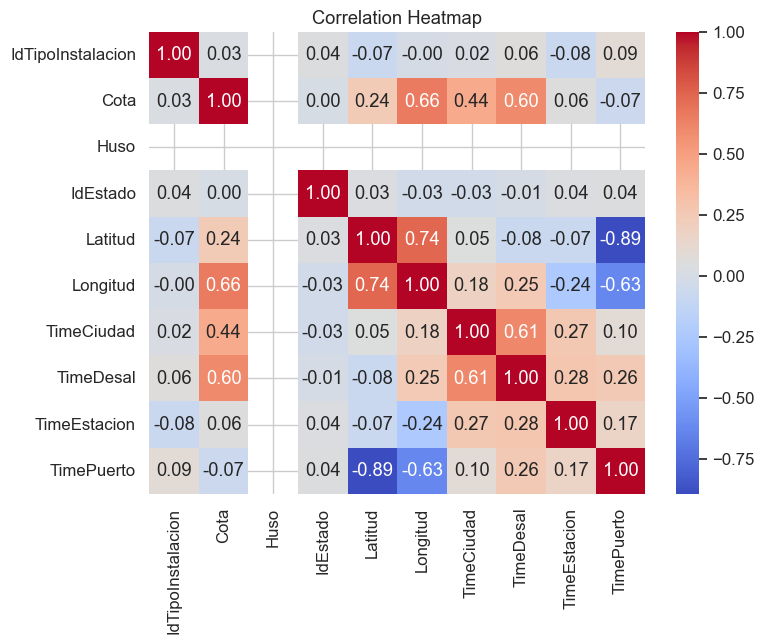

In [13]:
numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [14]:
df_desal = pd.read_csv("Bases/plantas_desaladoras_combinado_final.csv")
df_estaciones = pd.read_csv("Bases/estaciones2.csv")   
df_desal["Latitud"] = df_desal["Latitude"].astype(str).str.replace(",", ".").astype(float)
df_desal["Longitud"] = df_desal["Longitude"].astype(str).str.replace(",", ".").astype(float)
df_estaciones["lat"] = df_estaciones["latitude"].astype(float)
df_estaciones["lon"] = df_estaciones["longitude"].astype(float)

In [15]:
df_puertos = pd.read_csv("Bases/puertos.csv")

In [16]:
import folium
from folium.plugins import MarkerCluster
import webbrowser

# ===========================================
# 3️⃣ Crear mapa base
# ===========================================
map_chile = folium.Map(location=[-26.5, -70.7], zoom_start=5, tiles="CartoDB positron")

# ===========================================
# 4️⃣ Cluster Minas ACTIVA
# ===========================================
active_mining_cluster = MarkerCluster(name="Minas ACTIVAS").add_to(map_chile)

for _, row in df[df["Estado"] == "ACTIVA"].iterrows():
    popup_text = (
        f"<b>Empresa:</b> {row['NombreEmpresa']}<br>"
        f"<b>Estado:</b> {row['Estado']}<br>"
        f"<b>Tipo:</b> {row['TipoInstalacion']}<br>"
        f"<b>Provincia:</b> {row['ProvinciaInstalacion']}<br>"
        f"<b>Comuna:</b> {row['ComunaInstalacion']}<br>"
        f"<b>Recurso Primario:</b> {row['RecursoPrimarioInstalacion']}"
    )
    folium.Marker(
        location=[row["Latitud"], row["Longitud"]],
        popup=popup_text,
        tooltip=row["NombreEmpresa"],
        icon=folium.Icon(color="green", icon="industry", prefix="fa"),
    ).add_to(active_mining_cluster)

# ===========================================
# 5️⃣ Cluster Minas NO ACTIVAS
# ===========================================
inactive_mining_cluster = MarkerCluster(name="Minas NO ACTIVAS").add_to(map_chile)

for _, row in df[df["Estado"] != "ACTIVA"].iterrows():
    popup_text = (
        f"<b>Empresa:</b> {row['NombreEmpresa']}<br>"
        f"<b>Estado:</b> {row['Estado']}<br>"
        f"<b>Tipo:</b> {row['TipoInstalacion']}<br>"
        f"<b>Provincia:</b> {row['ProvinciaInstalacion']}<br>"
        f"<b>Comuna:</b> {row['ComunaInstalacion']}<br>"
        f"<b>Recurso Primario:</b> {row['RecursoPrimarioInstalacion']}"
    )
    folium.Marker(
        location=[row["Latitud"], row["Longitud"]],
        popup=popup_text,
        tooltip=row["NombreEmpresa"],
        icon=folium.Icon(color="red", icon="industry", prefix="fa"),
    ).add_to(inactive_mining_cluster)

# ===========================================
# 6️⃣ Cluster Desaladoras
# ===========================================
desal_cluster = MarkerCluster(name="Desaladoras").add_to(map_chile)
for _, row in df_desal.iterrows():
    popup_text = (
        f"<b>Empresa:</b> {row['Empresa/Operador']}<br>"
        f"<b>Planta:</b> {row['Nombre de la Planta']}<br>"
        f"<b>Tipo:</b> {row['Tipo de Planta']}<br>"
        f"<b>Uso:</b> {row['Uso/Aplicación']}<br>"
        f"<b>Estado:</b> {row['Estado Operacional']}<br>"
        f"<b>Capacidad (L/s):</b> {row['Capacidad (Valor)']}<br>"
        f"<b>Año Puesta en Marcha:</b> {row['Año de Puesta en Marcha']}<br>"
        f"<b>Región:</b> {row['Región']}"
    )
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=popup_text,
        tooltip=row["Nombre de la Planta"],
        icon=folium.Icon(color="blue", icon="tint", prefix="fa"),
    ).add_to(desal_cluster)

# ===========================================
# 7️⃣ Cluster Estaciones
# ===========================================
station_cluster = MarkerCluster(name="Estaciones Ferroviarias").add_to(map_chile)
for _, row in df_estaciones.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"<b>Estación:</b> {row['name']}",
        tooltip=row["name"],
        icon=folium.Icon(color="orange", icon="train", prefix="fa"),
    ).add_to(station_cluster)

# ===========================================
# 8️⃣ Cluster Puertos
# ===========================================
port_cluster = MarkerCluster(name="Puertos").add_to(map_chile)
for _, row in df_puertos.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"<b>Puerto:</b> {row['portName']}<br><b>Tamaño:</b> {row['harborSize']}",
        tooltip=row["portName"],
        icon=folium.Icon(color="purple", icon="ship", prefix="fa"),
    ).add_to(port_cluster)

# ===========================================
# 9️⃣ Control de capas
# ===========================================
folium.LayerControl(collapsed=False).add_to(map_chile)

# ===========================================
# 🔟 Guardar y abrir mapa
# ===========================================
map_file = "mapa_completo_chile_activas.html"
map_chile.save(map_file)
webbrowser.open(map_file)


True